# uplet movies

In [52]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

import threading

import warnings
warnings.filterwarnings('ignore')

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #w = cluster.scale(jobs=10)
    w = cluster.scale(jobs=5)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [29]:
bbox = [13, 18, -35, -32]
face = 1

In [3]:
root_dir = os.path.join(ut.work_data_dir,"parcels") 

#run_name = "global_dij8_up3_r1s111_15j"
#run_name = "global_dij8_up3_r2s111_15j"
#run_name = "global_dij8_up3_r1s111_30j_201202"
#run_name = "global_dij8_up3_r1s111_30j_201205"
#run_name = "global_dij8_up3_r2s111_30j_201202"
#run_name = "global_dij8_up3_r2s111_30j_201205"
run_name = "global_dij8_up3_r2s111_30j_201208"
#run_name = "global_dij8_up3_r2s111_30j_201112"

ds_info, dirs = pa.load_logs(root_dir, run_name)
#df_1d = pa.load_nc(dirs["run"], index='trajectory', step_tile="00*-*")

In [21]:
ds = xr.open_zarr(os.path.join(dirs["parquets"], "uplet.zarr"))

In [24]:
t_start = ds.time[0].values
t_end= t_start + pd.Timedelta('6H')

In [25]:
ds = ds.sel(time=slice(t_start, t_end))
#ds = ds.where( (ds.lon_init_uplet>bbox[0]) & (ds.lon_init_uplet<bbox[1]) 
#              & (ds.lat_init_uplet>bbox[2]) & (ds.lat_init_uplet<bbox[3]) )

# -180 to 180
#ds.lon_init_uplet.plot()

traj = ds.compute()

In [39]:
# load llc data
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
ds = ds.sel(time=slice(t_start, t_end), face=face)
grd = ut.load_grd(V=["XC", "YC", "XG", "YG", "Depth"]).sel(face=face)
llc = xr.merge([ds, grd])

---

## plot

In [ ]:
#import threading

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

In [32]:
out_dir = "/home1/scratch/aponte/figs"

In [50]:
def make_plot(ds, i):
    #MPL_LOCK = threading.Lock()
    #with MPL_LOCK:
    plt.switch_backend("agg")
    
    t = ds.time.values
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    # plot background
    ds.SST.plot(x="XC", y="YC", ax=ax, vmin=15, vmax=20, cmap="inferno")
    
    # plot trajectories
    #_traj = traj.sel(time=t)
    #ax.scatter(_traj.lon, _traj.lat, s=10, c="w")
    #
    dt_trail = pd.Timedelta("1D")
    _traj = traj.sel(time=slice(t-dt_trail, t))
    ax.scatter(_traj.lon, _traj.lat, s=10, c="w")
    #ax.plot(_traj.lon, _traj.lat, c="w")
    
    
    ax.set_xlim(bbox[0], bbox[1])
    ax.set_ylim(bbox[2], bbox[3])
    
    ax.set_title(f"{i}", fontdict={"fontsize": 20, "fontweight": "bold"})
    #
    savefig = os.path.join(out_dir, f"{i:03d}.png")
    fig.savefig(savefig, dpi=150)
    plt.close(fig)


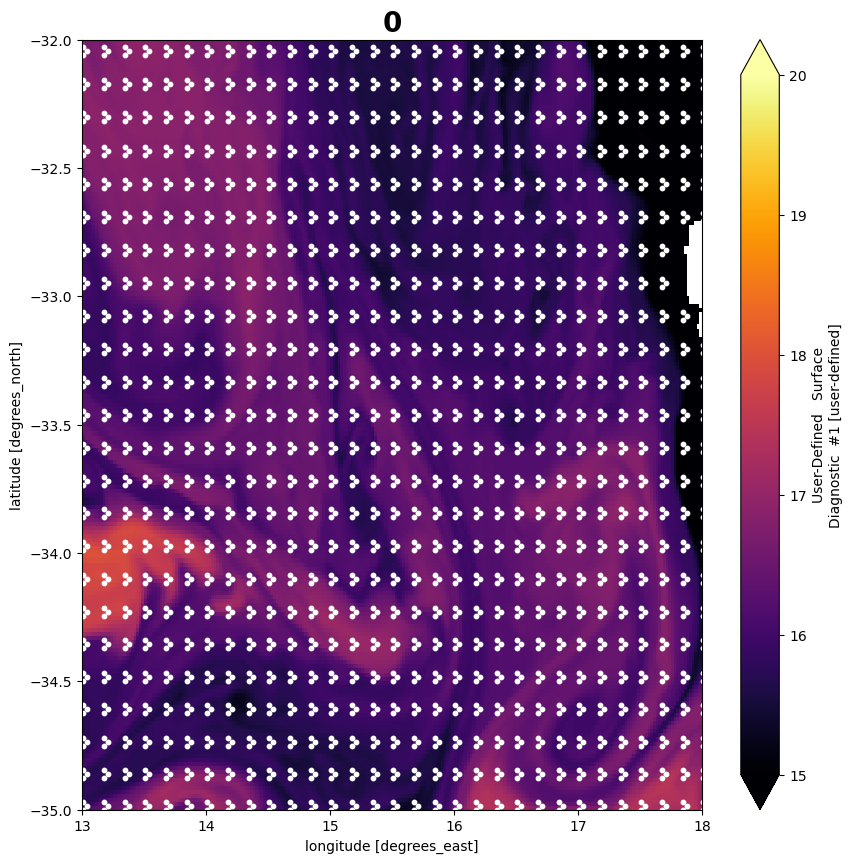

In [49]:
t = t_start+pd.Timedelta("2H")
i=0
make_plot(llc.sel(time=t_start), i)

In [51]:
for t, i in zip(traj.time, range(traj.time.size)):
    make_plot(llc.sel(time=t), i)

## Close cluster

In [ ]:
cluster.close()